# Irony Simulations
## Imports

In [23]:
import sys
sys.path.append("/home/sathya/projects/RSAsimulations/src")

import logging
import pickle
from typing import Tuple, List, Optional

import hydra
import numpy
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import omegaconf
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import image_captioning.sample as visual_model
import lexicon
import physiological
from image_captioning.build_vocab import Vocabulary
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import Predictive
from physiological import ecg_model_forward, ecg_model_inverse, eda_model_forward, eda_model_inverse
from face import face_model

import utils

# Double precision for numerical stability
torch.set_default_dtype(torch.float64)

## Loading data and models

In [7]:
STATES: Tuple[str, ...] = ("terrible", "ok", "amazing")
GOALS: Tuple[str, ...] = ("goal_state", "goal_valence", "goal_arousal")
AROUSAL_VALUES: Tuple[str, str] = ("low", "hi")

In [8]:
# Load the configuration file
CONFIG_PATH = "/home/sathya/projects/RSAsimulations/config/irony_config.yaml"
cfg = omegaconf.OmegaConf.load(CONFIG_PATH)

## Helper functions

## RSA model priors

In [9]:
STATE_PRIOR = [1, 50, 50]
# Here we introduce the RSA functions - we start with priors
def state_prior() -> str:
    probs: torch.Tensor = torch.FloatTensor(STATE_PRIOR)
    ix: torch.Tensor = pyro.sample("state", dist.Categorical(probs=probs))

    return STATES[ix.item()]

In [10]:
def valence_prior(state: str) -> float:
    # Prior probability of having LOW valence given a particular state
    ps = {"terrible": 0.99, "ok": 0.5, "amazing": 0.01}

    return ps[state]

In [11]:
def arousal_prior(state: str) -> float:
    # Prior probability of having HIGH arousal given a particular state
    ps = {"terrible": 0.9, "ok": 0.1, "amazing": 0.9}

    return ps[state]

In [12]:
def goal_state(goal: str, state, valence, arousal):
    if goal == "goal_state":
        return state
    elif goal == "goal_valence":
        return valence
    elif goal == "goal_arousal":
        return arousal

In [13]:
def goal_prior() -> str:
    # Uniform prior on the goals
    probs: torch.Tensor = torch.ones(len(GOALS)) / len(GOALS)
    goal_index: int = pyro.sample("goal", dist.Categorical(probs=probs)).item()

    return GOALS[goal_index]

In [14]:
def utterance_prior():
    # Utterances and states are equivalent in our case
    utterances = STATES

    # Uniform prior on the goals
    probs: torch.Tensor = torch.ones(len(utterances)) / len(utterances)
    utterance_index: int = pyro.sample("utterance", dist.Categorical(probs=probs)).item()

    return utterances[utterance_index]


## RSA model core functions

In [15]:
# Sampling valence given state and any other sources of valence
def sample_valence(state) -> int:
    sampled_valence_prior = valence_prior(state)

    sample = pyro.sample(
        "valence_prior",
        dist.Bernoulli(probs=sampled_valence_prior)
    ).item()

    # Recall that the probabilities are inverted for valence in the prior
    return -1 if sample == 1 else 1

In [16]:
# Sampling arousal given state and any other sources of arousal
def sample_arousal(state):
    sampled_arousal_prior = arousal_prior(state)

    sample = pyro.sample(
        "arousal_prior",
        dist.Bernoulli(probs=sampled_arousal_prior)
    ).item()

    # Here the probabilities are not inverted
    return AROUSAL_VALUES[int(sample)]


In [17]:
# Define RSA meaning function
def literal_interpretation(utterance: str, state: str) -> bool:
    # This is our meaning function
    return utterance == state

In [18]:
# Literal listener
@utils.marginal
def literal_listener(utterance, goal):
    sampled_state = state_prior()

    sampled_valence = sample_valence(sampled_state)
    sampled_arousal = sample_arousal(sampled_state)

    sampled_goal = goal_state(goal, sampled_state, sampled_valence, sampled_arousal)

    log_factor: torch.Tensor = torch.tensor(0.0) if literal_interpretation(utterance, sampled_state) \
        else torch.tensor(-999999.0)
    pyro.factor("literal_meaning", log_factor=log_factor)

    return sampled_goal

In [19]:
# Pragmatic speaker
@utils.marginal
def pragmatic_speaker(state: str, valence: float, arousal: float, goal: str) -> str:
    alpha_scaling_factor: float = 1.0

    sampled_goal: str = goal_state(goal, state, valence, arousal)

    with poutine.scale(scale=torch.tensor(alpha_scaling_factor)):
        sampled_utterance = utterance_prior()
        literal_listener_goal = literal_listener(sampled_utterance, goal)
        pyro.sample("listener", literal_listener_goal, obs=sampled_goal)

    return sampled_utterance

In [20]:
# Pragmatic listener
@utils.marginal
def pragmatic_listener(utterance: str):
    sampled_state = state_prior()
    sampled_valence = sample_valence(
        sampled_state
    )
    sampled_arousal = sample_arousal(
        sampled_state
    )
    sampled_goal = goal_prior()

    speaker_marginal = pragmatic_speaker(sampled_state, sampled_valence, sampled_arousal, sampled_goal)
    pyro.sample("speaker", speaker_marginal, obs=utterance)

    return sampled_state, sampled_valence, sampled_arousal, sampled_goal

## Experiments

In [21]:
PLOT_WIDTH = 15
PLOT_HEIGHT = 8
matplotlib.rcParams['figure.figsize'] = [PLOT_WIDTH, PLOT_HEIGHT]

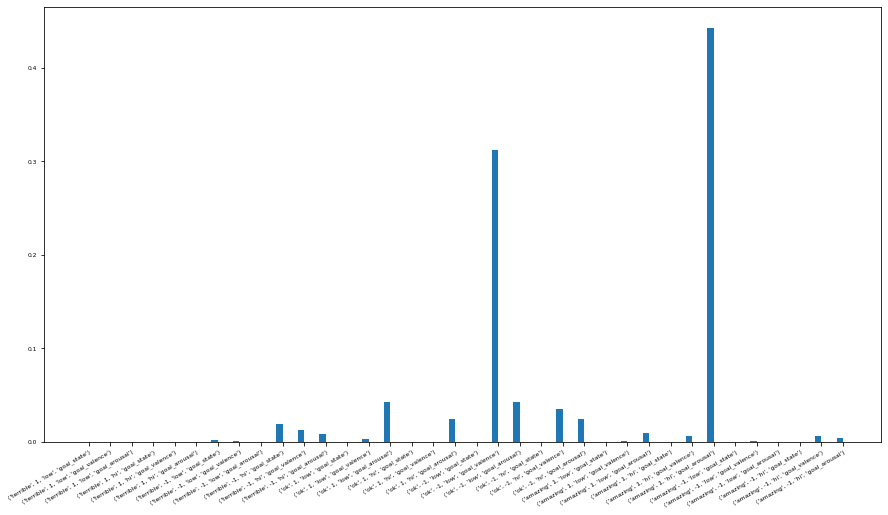

In [40]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("terrible")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/sathya/final_plots/irony_orig_terrible.pdf")

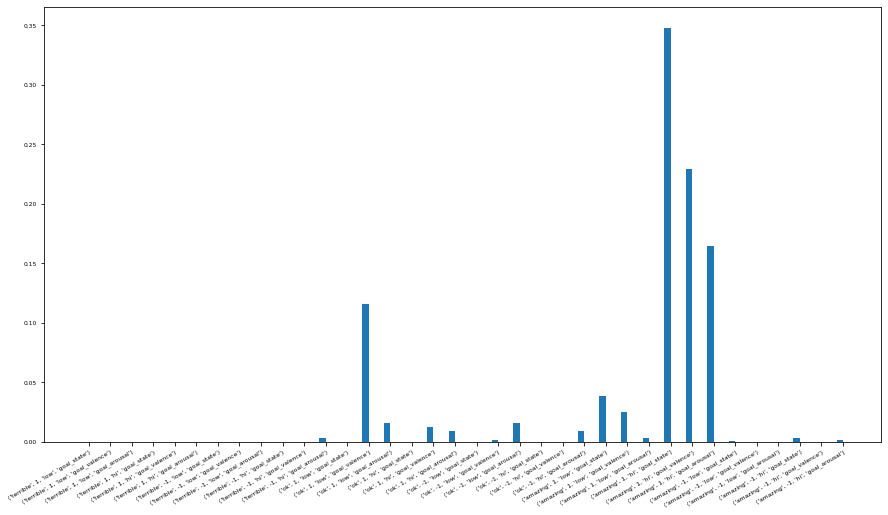

In [38]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("amazing")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/sathya/final_plots/irony_orig_amazing.pdf")

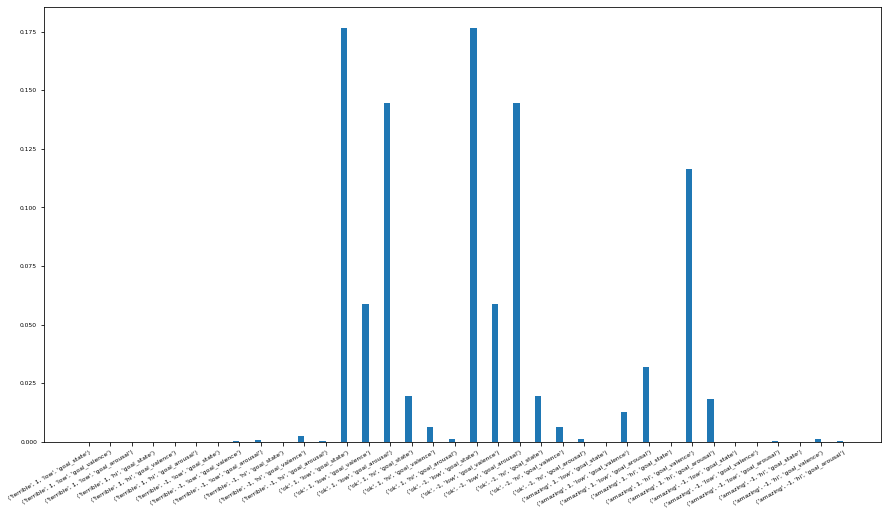

In [37]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("ok")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/sathya/final_plots/irony_orig_ok.pdf")

### Altering the state prior

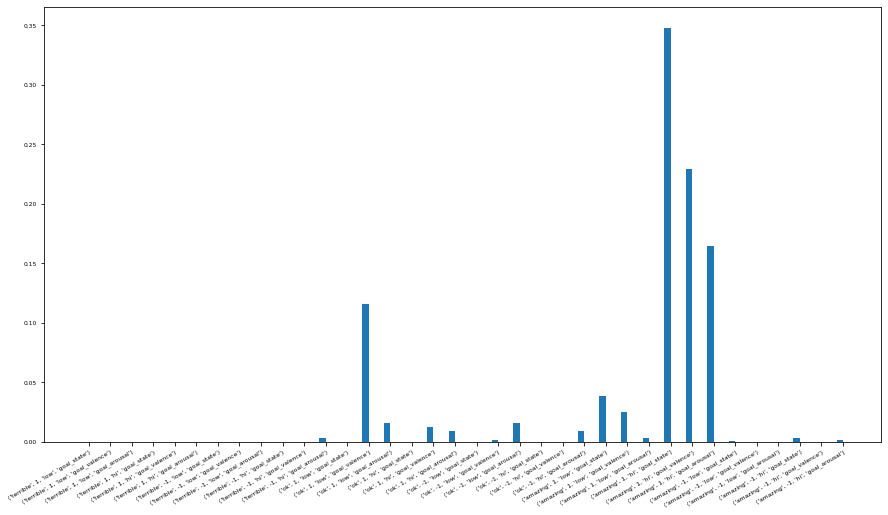

In [33]:
STATE_PRIOR = [1, 50, 1]
rsa_posterior = pragmatic_listener("amazing")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/sathya/final_plots/irony_orig_.pdf")

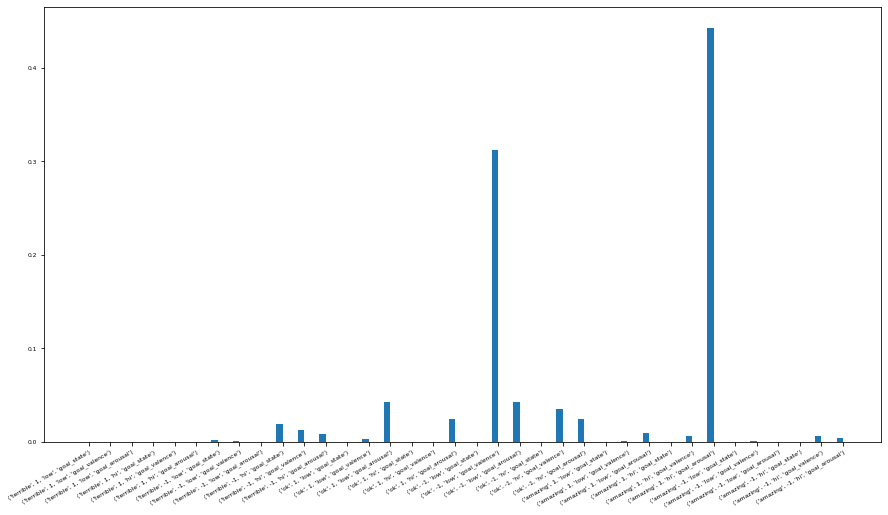

In [36]:
STATE_PRIOR = [100, 1, 1]
rsa_posterior = pragmatic_listener("terrible")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/sathya/final_plots/irony_orig_.pdf")